In [84]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import documents as docs
import textcomparisons as tc
import random
import time
import json

def readArticles(path):
    """ Reads df of articles from the given path, and adds a column
    to store the Document-processed article """
    article_df = pd.read_csv(path)
    article_df["doc"] = None
    return article_df

def dict_by_ids(df, ids):
    """ Given a dataframe of articles and a list of article ids, 
    returns a dictionary with ids as keys and Documents as items, 
    computing and storing the Documents back in the df as needed
    """
    doc_dict = {}
    for doc_id in ids:
        row = df["id"] == doc_id
        doc = df.loc[row, "doc"].iloc[0]
        if doc is None:
            doc = docs.Document(df.loc[row, "text"].iloc[0], clean = False)
            df.loc[row, "doc"] = doc
        doc_dict[doc_id] = doc
    return doc_dict

data_folder = "data"
article_files = ["articles2019-05-31_0-7000.csv",
                 "articles2019-05-31_7000-14000.csv",
                 "articles2019-05-31_14000-16654.csv"]
article_df = [readArticles(os.path.join(data_folder, file)) for file in article_files]

article_df = pd.concat(article_df)
article_df = article_df.reset_index()

events = [event for event in np.unique(article_df["event"]) if not np.isnan(event)]
with open(event_path, encoding = "utf8") as json_file:
    events = json.load(json_file)
print(events.keys())
article_df.head(3)

dict_keys(['singletons', 'incompleteFingerprints', 'algoGroups', 'events', 'wordDict', 'entityDict'])


,index,id,publisher,scrape_time,on_homepage,url,title,text,fingerprint,event,doc
0,0,0,sfgate.com,2019-05-31T07:45:29-04:00,False,https://www.sfgate.com/news/article/Beto-O-Rou...,"Beto O'Rourke bolstering Iowa staff, field off...","Beto O'Rourke bolstering Iowa staff, field off...","{'wordCounts': {'31293': 2, '38276': 5, '15430...",NaN,None
1,1,1,centurylink.net/news,2019-05-31T11:36:56-04:00,True,https://centurylink.net/news/read/category/new...,Robbins Geller Rudman & Dowd LLP Announces Pro...,TO: ### ALL PERSONS WHO PURCHASED DIPLOMAT PHA...,"{'wordCounts': {'744': 3, '421': 3, '13018': 5...",NaN,None
2,2,2,news.google.com,2019-05-31T15:32:23-04:00,True,https://news.google.com/stories/CAAqOQgKIjNDQk...,NaN,iMoreverified_user ### iMore ### From buying u...,"{'wordCounts': {'710161': 1, '403001': 1, '226...",NaN,None


In [87]:
N = len(article_df)
N_top50 = np.sum(1 - np.isnan(article_df["event"]))
print("Number of singletons: %d" % len(events['singletons']))
print("Number of articles clustered into top 50 events: %d/%d (.%d)" % (N_top50, N, round(N_top50/N, 2) * 100))

ac = tc.ArticleComparisons()

Number of singletons: 10683
Number of articles clustered into top 50 events: 4072/16654 (.24)


Text(0.5, 1.0, 'Number of sentences in 250 sample articles')

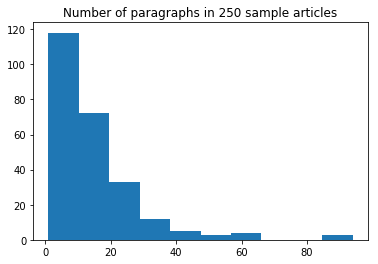

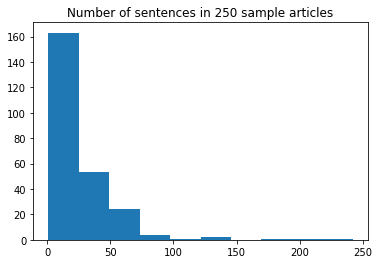

In [114]:
n = 250
sample = article_df.loc[random.sample(range(len(article_df)), n), "id"]
article_dict = dict_by_ids(article_df, sample)

n_paras = [len(article_dict[id].paragraphs) for id in article_dict.keys()]
n_sentences = [len(article_dict[id].get_sentences()) for id in article_dict.keys()]

plt.hist(n_paras)
plt.title("Number of paragraphs in %d sample articles" % n)

plt.figure()
plt.hist(n_sentences)
plt.title("Number of sentences in %d sample articles" % n)

In [ ]:
score_mat = ac.jac_score_mat(article_dict, weighted = False)
axislabels = list(article_dict.keys())
clusters = ac.get_article_clusters()
ac.prop_unique_clusters()

0 / 250 done, 0.0 seconds elapsed
25 / 250 done, 81.39 seconds elapsed


In [20]:

sample = article_df.loc[random.sample(events['singletons'], 200), "id"]
#sample = article_df.loc[article_df["event"] == events[5], "id"]

start = time.time()

score_mat = ac.jac_score_mat(article_dict, weighted = False)
axislabels = list(article_dict.keys())
axislabels

print("%s seconds taken" % np.round(time.time() - start, 2))
# 1000 comparisons takes ~15s: estimated >2 hours for 1000 articles 
# takes about ~1min for 100 docs, ~4min for 120 docs (44%), ~28min for 321 docs (event 6, 62%), 
# 100 singleton articles: 96%, 200 (10min): 93%

0 / 200 done, 0.0 seconds elapsed
20 / 200 done, 179.87 seconds elapsed
40 / 200 done, 293.55 seconds elapsed
60 / 200 done, 360.66 seconds elapsed
80 / 200 done, 428.94 seconds elapsed
100 / 200 done, 503.53 seconds elapsed
120 / 200 done, 558.36 seconds elapsed
140 / 200 done, 604.19 seconds elapsed
160 / 200 done, 626.25 seconds elapsed
180 / 200 done, 648.15 seconds elapsed
680.11 seconds taken


In [62]:
ac.get_article_clusters()
ac.prop_unique_clusters()

NameError: name 'ac' is not defined

Average % unique articles in clusters, weighted by cluster size:  0.5370874263261297


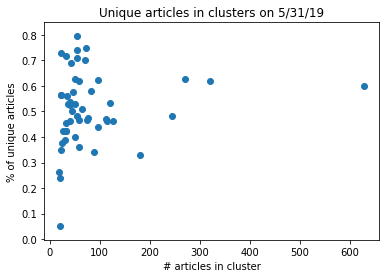

In [61]:
results = pd.read_csv("results_20190531_clusters.csv")
plt.scatter(results.loc[:, "n"], results.loc[:, "unique"])
plt.title("Unique articles in clusters on 5/31/19")
plt.xlabel("# articles in cluster")
plt.ylabel("% of unique articles")
print("Average % unique articles in clusters, weighted by cluster size: ", np.sum(results.loc[:, "n"] * results.loc[:, "unique"])/np.sum(results.loc[:, "n"]))